In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/chandniagarwal/Gan_Classifier.git

Cloning into 'Gan_Classifier'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 48 (delta 13), reused 46 (delta 11), pack-reused 0
Receiving objects: 100% (48/48), 835.10 KiB | 15.76 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [3]:
!mkdir training
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/recon /content/training/recon
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/celebagt /content/training/ground
!cp -r /content/drive/MyDrive/researchwork_15.9.203/testing /content/testing

In [4]:
import sys
sys.path.append('/content/Gan_Classifier/src')
import glob
import os
import numpy as np
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers


from keras.models import Sequential
from keras.layers import Input, Dense, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import time
import random
import seaborn as sns
from DatasetCreation import DatasetCreation
from Model import Model
from ElmModel import elm
from numba import cuda

In [5]:
tf.random.set_seed(
    42
)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
list_images=[]
labels=[]

In [6]:
# Testing Data Location
test_gt = "/content/drive/MyDrive/researchwork_15.9.203/testing/gt"
test_gen = "/content/drive/MyDrive/researchwork_15.9.203/testing/gen"
test_ec = "/content/drive/MyDrive/researchwork_15.9.203/testing/ec"
test_vqvae = "/content/drive/MyDrive/researchwork_15.9.203/testing/vqvae"
test_mask = "/content/drive/MyDrive/imageclassificationmodel/dataset/mask2000"
test_unmask = "/content/drive/MyDrive/imageclassificationmodel/dataset/gt2000"

In [7]:
# test_gt = '/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/e3'
# test_vqvae='/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/g3'

In [8]:
# Training Data Location
train_gt='/content/training/ground'
train_recon='/content/training/recon'

In [9]:
# training Data
image_loc_ground = glob.glob(train_gt+"/*.jpg")
labels = len(image_loc_ground) * ["ground"]
image_loc_recon = glob.glob(train_recon+"/*.jpg")

labels += len(image_loc_recon) * ["recon"]
image_loc = image_loc_ground + image_loc_recon

training_dataset = DatasetCreation(image_loc, labels, "one_hot")
# for 152 layer
training_dataset_152_layer = DatasetCreation(
    image_loc, labels, "one_hot", tf.keras.applications.resnet50.preprocess_input
)
print(training_dataset.images.shape)
print(training_dataset.labels.shape)

_________Loading Images__________


100%|██████████| 7178/7178 [00:22<00:00, 316.62it/s]


_________Loading Images__________


100%|██████████| 7178/7178 [00:13<00:00, 548.06it/s]


(7178, 224, 224, 3)
(7178, 2)


## Load Softmax Model

In [10]:
def load_model(model_function, trainable:bool):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = trainable

  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [11]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, True)
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, True)
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, True)

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, False)
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, False)
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, False)

234698864/234698864 [==============================] - 11s 0us/step
Running time: 19.6264 seconds
171446536/171446536 [==============================] - 8s 0us/step
Running time: 11.9464 seconds
94765736/94765736 [==============================] - 5s 0us/step
Running time: 7.0804 seconds
Running time: 5.0275 seconds
Running time: 3.3002 seconds
Running time: 1.7180 seconds


In [12]:
# best model calculate before the notebook crashed
model_resnet_152_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/152_full/weights.06-0.02-0.99.hdf5")
model_resnet_101_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/101_full/weights.10-0.01-1.00.hdf5")
model_resnet_50_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/50_full/weights.09-0.05-0.99.hdf5")
model_resnet_152_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/152_freeze/weights.03-0.35-0.83.hdf5")
model_resnet_101_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/101_freeze/weights.08-0.67-0.65.hdf5")
model_resnet_50_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/50_freeze/weights.01-0.65-0.64.hdf5")

In [13]:
model_softmax = {
    "152_full": model_resnet_152_full,
    "101_full": model_resnet_101_full,
    "50_full": model_resnet_50_full,
    "152_freeze": model_resnet_152_freeze,
    "101_freeze": model_resnet_101_freeze,
    "50_freeze": model_resnet_50_freeze,
}
model_data_train = {
    "152_full": training_dataset_152_layer,
    "101_full": training_dataset,
    "50_full": training_dataset,
    "152_freeze": training_dataset_152_layer,
    "101_freeze": training_dataset,
    "50_freeze": training_dataset,
}

In [14]:
for key in model_softmax.keys():
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")

## Load Test Data

In [15]:
# test Data
image_loc_ground = glob.glob(test_gt+"/*.jpg")
label_ground = len(image_loc_ground) * ["ground"]

image_loc_gen = glob.glob(test_gen+"/*.jpg")
label_gen = len(image_loc_gen) * ["recon"]

image_loc_ec = glob.glob(test_ec+"/*.jpg")
label_ec = len(image_loc_ec) * ["recon"]

image_loc_vqvae = glob.glob(test_vqvae+"/*.jpg")
label_vqvae = len(image_loc_vqvae) * ["recon"]

test_dataset = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary"
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary"
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary"
        ),
}

test_dataset_152_layer = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
}
model_data = {
    "152_full": test_dataset_152_layer,
    "101_full": test_dataset,
    "50_full": test_dataset,
    "152_freeze": test_dataset_152_layer,
    "101_freeze": test_dataset,
    "50_freeze": test_dataset,
}

_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 202.08it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 229.11it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 217.84it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 273.34it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 282.07it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 268.63it/s]


## Softmax ELM

In [16]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

In [17]:
def batch_predict(model, images, batch=32):
  array1 = []
  for idx in range(0, len(images), batch):
    array2 = model.predict(images[idx: min(len(images), idx+batch)], verbose = 0)

    if len(array1)>0:
      array1 = np.concatenate((array1, array2), axis=0)
    else:
      array1 = array2
  return array1

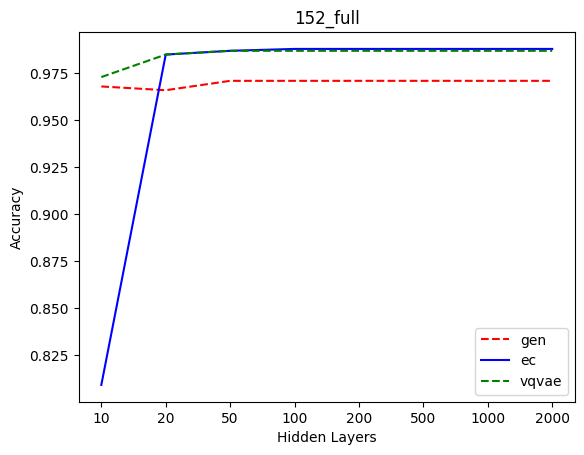

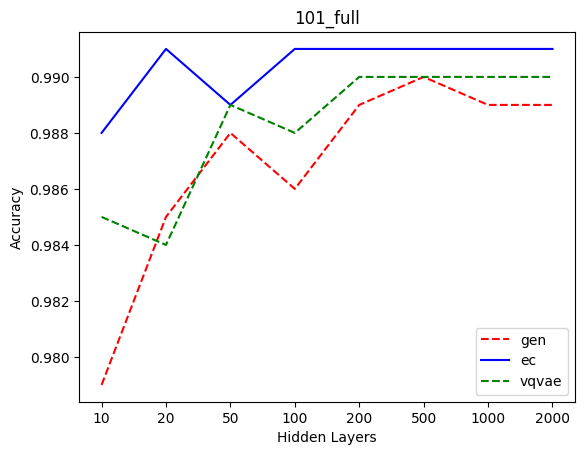

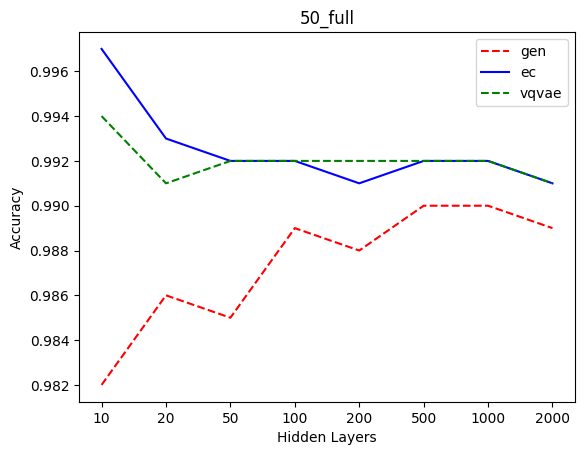

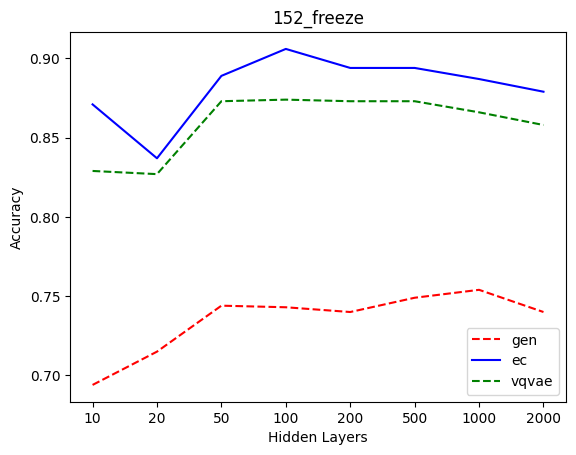

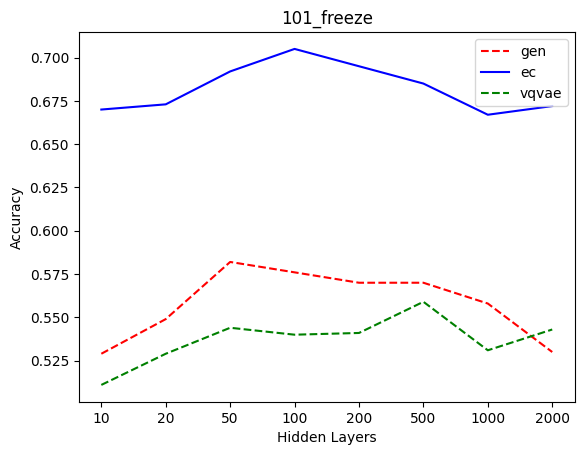

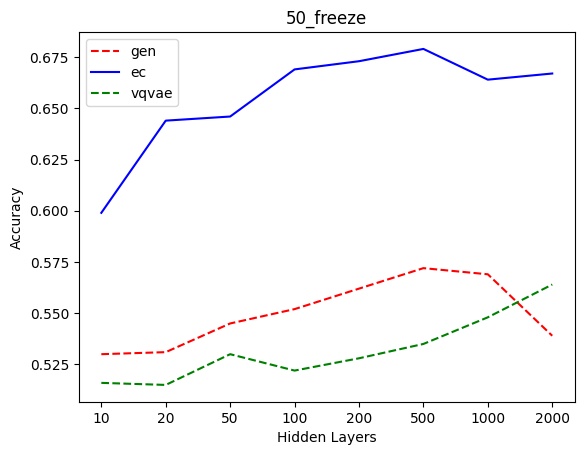

In [18]:
for model_name in model_softmax.keys():
  Xtrain = batch_predict(model_softmax[model_name].headless_model, model_data_train[model_name].images, 8)
  Ytrain = model_data_train[model_name].labels[...,0] == 0

  accuracy = {}
  hidden_layers = [10,20,50,100,200,500,1000,2000]

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 8)
    for layer in hidden_layers:
      model_elm = elm(hidden_units=layer, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
      beta, train_accuracy, running_time = model_elm.fit('solution2')
      y_result = model_elm.predict(Xtest)
      labels = model_data[model_name][key].labels
      acc_sp = accuracy.get(key, [])
      acc_sp.append(accuracy_score(y_result, labels))
      accuracy[key] = acc_sp

  # Visualize Test Accuracy
  hidden_layer_range = range(len(hidden_layers))
  plt.title(model_name)
  plt.plot(hidden_layer_range, accuracy["gen"], 'r--')
  plt.plot(hidden_layer_range, accuracy["ec"], 'b-')
  plt.plot(hidden_layer_range, accuracy["vqvae"], 'g--')
  plt.xticks(hidden_layer_range, hidden_layers)
  plt.legend(['gen', 'ec', 'vqvae'])
  plt.xlabel('Hidden Layers')
  plt.ylabel('Accuracy')
  plt.show();

## Load Sigmoid Model

In [19]:
def load_model(model_function, trainable:bool):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = trainable

  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [20]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, True)
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, True)
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, True)

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, False)
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, False)
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, False)

Running time: 5.7062 seconds
Running time: 3.4436 seconds
Running time: 1.7781 seconds
Running time: 5.0771 seconds
Running time: 3.3604 seconds
Running time: 1.7088 seconds


In [26]:
# best model calculate before the notebook crashed
model_resnet_152_full.load_weights("/content/drive/MyDrive/final_model/checkpoint_sigmoid/152_full/weights.10-0.01-1.00.hdf5")
model_resnet_101_full.load_weights("/content/drive/MyDrive/final_model/checkpoint_sigmoid/101_full/weights.10-0.02-1.00.hdf5")
model_resnet_50_full.load_weights("/content/drive/MyDrive/final_model/checkpoint_sigmoid/50_full/weights.10-0.02-0.99.hdf5")
model_resnet_152_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint_sigmoid/152_freeze/weights.05-0.32-0.86.hdf5")
model_resnet_101_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint_sigmoid/101_freeze/weights.01-0.70-0.52.hdf5")
model_resnet_50_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint_sigmoid/50_freeze/weights.06-0.63-0.71.hdf5")

In [27]:
model_softmax = {
    "152_full": model_resnet_152_full,
    "101_full": model_resnet_101_full,
    "50_full": model_resnet_50_full,
    "152_freeze": model_resnet_152_freeze,
    "101_freeze": model_resnet_101_freeze,
    "50_freeze": model_resnet_50_freeze,
}
model_data_train = {
    "152_full": training_dataset_152_layer,
    "101_full": training_dataset,
    "50_full": training_dataset,
    "152_freeze": training_dataset_152_layer,
    "101_freeze": training_dataset,
    "50_freeze": training_dataset,
}

In [28]:
for key in model_softmax.keys():
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")

## Elm Sigmoid

In [29]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

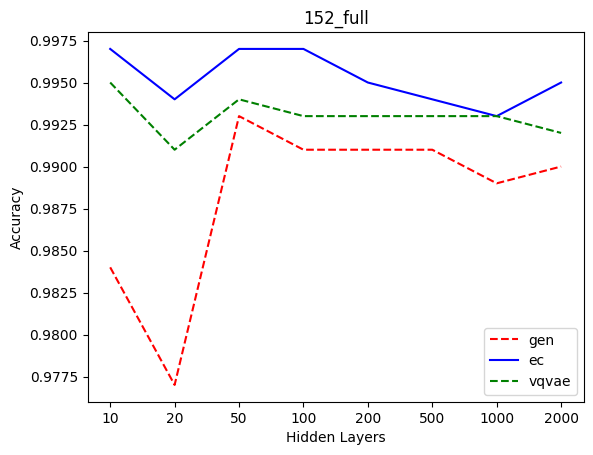

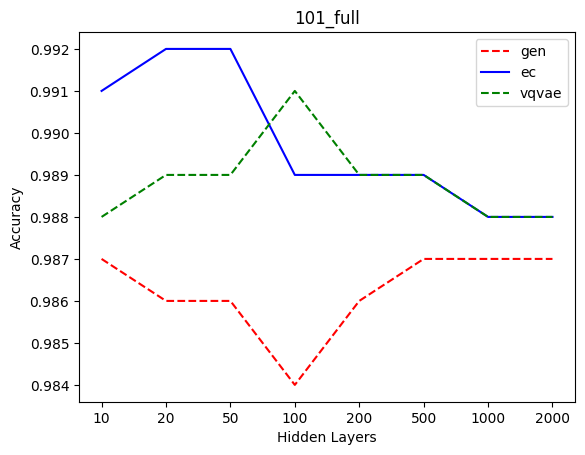

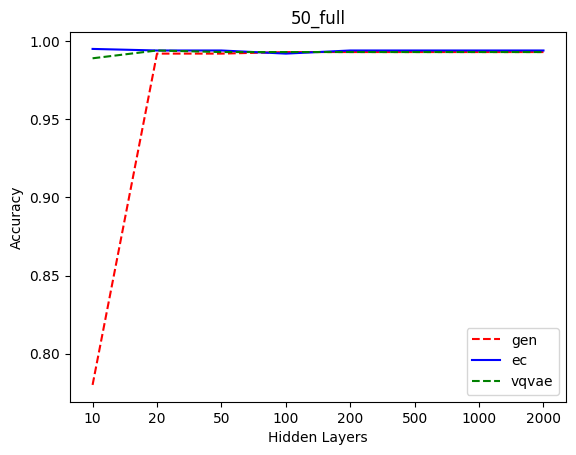

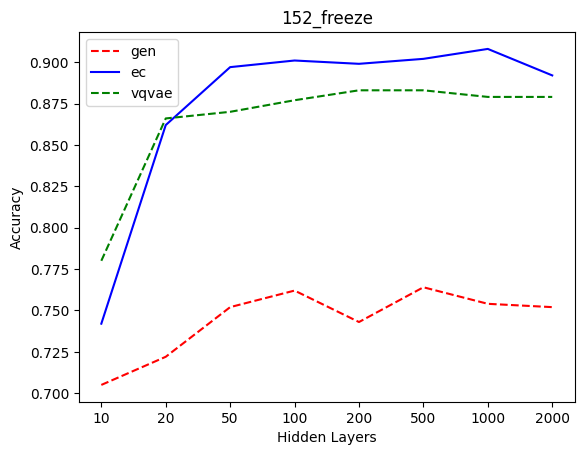

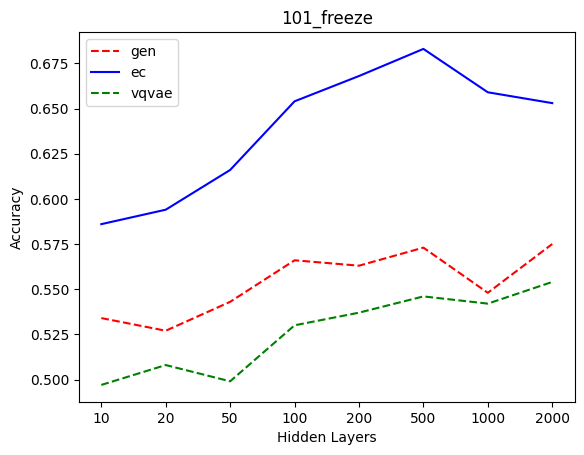

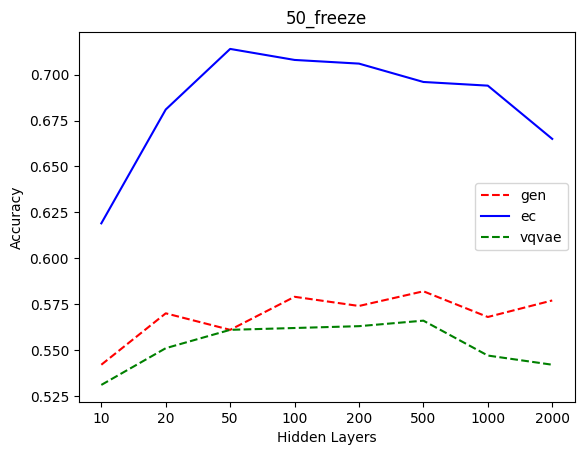

In [31]:
for model_name in model_softmax.keys():
  Xtrain = batch_predict(model_softmax[model_name].headless_model, model_data_train[model_name].images, 8)
  Ytrain = model_data_train[model_name].labels[...,0] == 0

  accuracy = {}
  hidden_layers = [10,20,50,100,200,500,1000,2000]

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 8)
    for layer in hidden_layers:
      model_elm = elm(hidden_units=layer, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
      beta, train_accuracy, running_time = model_elm.fit('solution2')
      y_result = model_elm.predict(Xtest)
      labels = model_data[model_name][key].labels
      acc_sp = accuracy.get(key, [])
      acc_sp.append(accuracy_score(y_result, labels))
      accuracy[key] = acc_sp

  # Visualize Test Accuracy
  hidden_layer_range = range(len(hidden_layers))
  plt.title(model_name)
  plt.plot(hidden_layer_range, accuracy["gen"], 'r--')
  plt.plot(hidden_layer_range, accuracy["ec"], 'b-')
  plt.plot(hidden_layer_range, accuracy["vqvae"], 'g--')
  plt.xticks(hidden_layer_range, hidden_layers)
  plt.legend(['gen', 'ec', 'vqvae'])
  plt.xlabel('Hidden Layers')
  plt.ylabel('Accuracy')
  plt.show();